# Section 6.3.13 The effect of irrigating the desert (south of Alexandria)

IHE, Delft, transient groundwater

@T.N.Olsthoorn, 2019-01-04

## Context

Effect of a rising lake on adjacent groundwater heads

South-west of Alexandria part of the Sahara desert has been reclaimed by irrigating with river Nile water since the 1970s. This area is about 30x30 km and the recharge is about 1.5 m/year, half of which is evaporated by the crops and half is recharged, i.e. largely lost for crop production (it may become too saline in the subsurface).

The Sahara aquifer is about 200 m thick and unconfined. The initial water table was at 30 below ground surface.

We can simulate this situation by means of Theis wells placed in a regular grid to simulate the area-wide irrigation and then superimpose the result to see what happens at arbitrary locations over time.

Of course, we may also make influence maps by computing the results for a grid of points and then contouring the results. This would just more computation time, but is not necesarily more complicated.

Let the center of the irrigated area coincide with our coordinate system.

## Loading modules

In [2]:
import numpy as np
from scipy.special import exp1 # Theis well function
import matplotlib.pyplot as plt

## Convenience funtion for setting up a graph

In [3]:
def newfig(title='?', xlabel='?', ylabel='?', xlim=None, ylim=None,
                   xscale='linear', yscale='linear', size_inches=(14, 8)):
    '''Setup a new axis for plotting'''
    fig, ax = plt.subplots()
    fig.set_size_inches(size_inches)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    ax.grid(True)
    return ax

## Implementation

In [11]:
# aquifer properties, because it make more sense here, we'll work in m and years instead of m and days
kD = 200 * 25 * (365) # m2/y (not m2/d)
S = 0.25 # [-], storage coefficient, does not change if we work in years or days

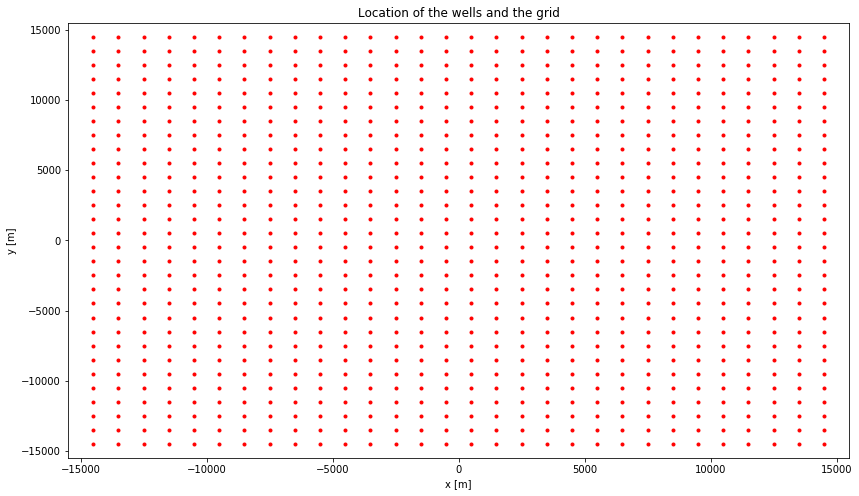

In [12]:
# place the wells, which are on a regular 1000x1000 grid to simulate the irrigation.
# The width and length of the irrigated area are both 30 km.
a = 1000. # m cell size
L = 30e3 # km
xw = np.linspace(-(L - a)/2, (L - a)/2, L/a) # m, coordinatres of the cell centers = well
yw = np.linspace(-(L - a)/2, (L - a)/2, L/a) # m, coordinaters of the cell centers = well

# Genrate full 2D arrays of the x and y coordinates of the wells. Becaus these are 2D arrays,
# I chose to use capital letters X and Y with a small w to show these are the irrigation well-coordinates
Xw, Yw = np.meshgrid(xw, yw) # 

# Show the wells
ax = newfig('Location of the wells and the grid', 'x [m]', 'y [m]',
            xlim=(-(L + a) / 2 , (L + a) / 2), ylim=(-(L + a) / 2, (L + a) / 2))
ax.grid(False)
ax.plot(Xw, Yw, 'r.')
plt.show() # See what happens if you omit plt.show()

In [13]:
# Recharge is irrigation - vaportranspiration is the loss of irrigation wat to the deep groundwater
# in the aquifer
q = 0.25 # m/y, the yearly recharge
Q = a**2 * q  # irrigation per well in m3/y (with so many wells this is a lot of water)

In [14]:
# Observation points, where we want to see what happens to the groundwater
# We jus take a few points on the y-axis, some inside the irrigated area some outside of it
Y0 = np.array([0, 10, 20, 40, 60]) * 1e3 # note the 1e3 factor which converts km to m
X0 = np.zeros_like(Y0) # only one valuenp.zeros_like(Y0) # same 

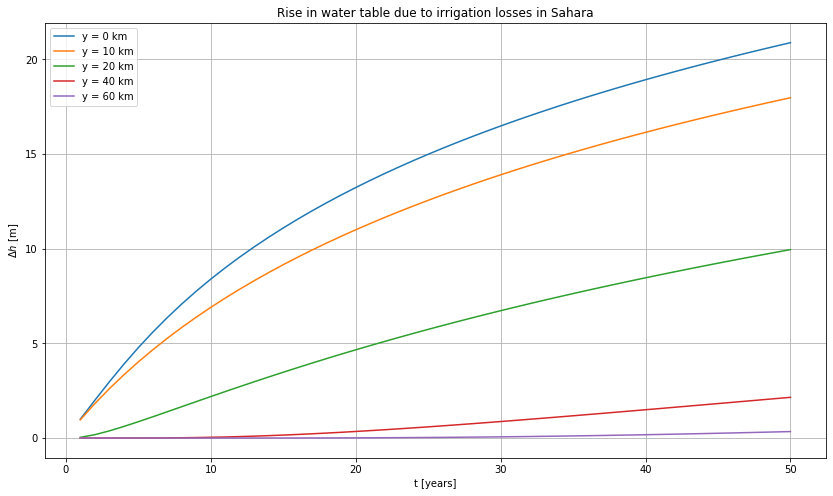

Point 0 at y=    0 m rises 0.179 m/y at t=50.0 y
Point 1 at y=10000 m rises 0.168 m/y at t=50.0 y
Point 2 at y=20000 m rises 0.140 m/y at t=50.0 y
Point 3 at y=40000 m rises 0.066 m/y at t=50.0 y
Point 4 at y=60000 m rises 0.019 m/y at t=50.0 y


In [28]:
# effect on observation point

t = np.linspace(0, 50, 51)[1:] # time in years, omit t[0] which is 0, to prevend division by zero.

F = Q / (4 * np.pi * kD) # need to compute this only once

result = dict() # Use a dict to store the results (for convenience of plotting later)

for i, (x0, y0) in enumerate(zip(X0, Y0)):
    R = np.sqrt((x0 - Xw)**2 + (y0 - Yw)**2).ravel()[:, np.newaxis] # shape is (900, 1)    
    T = R**2 * S / (4 * kD) # shape is (900, 1)
    # Compute the head change and add it to the dict together with its context (x0, y0 and index)
    # Shape of t[np.newaxis,:] will be (1, 51) so the T/t has shape (900, 51) (about 50000 points)
    # But because we sum over all R, (axis=0) we end up with 51 values. The summing over R is
    # the superposition over all 900 wells that contribute.
    result[i] = {'x': x0, 'y': y0, 's': np.sum(F * exp1(T / t[np.newaxis,:]), axis=0)}

# Show results    
ax = newfig('Rise in water table due to irrigation losses in Sahara', 't [years]', '$\Delta h$ [m]',
           xscale='linear')

for k in result:
    ax.plot(t, result[k]['s'], label='y = {:.0f} km'.format(result[k]['y']/1000))
ax.legend()
plt.show()

# The increase of head after 50 years
for k in result:
    data = result[k]
    data['rise'] = (data['s'][-1] - data['s'][-2]) / (t[-1] -  t[-2])
    print(f"Point {k} at y={data['y']:5.0f} m rises {data['rise']:.3f} m/y at t={t[-1]:.1f} y")

## Contour the head built up over 50 years irrigation

It is possible to plot contour lines. However this requires a lot of computation power, because
we have  900 wells that are superposed in each observation point and to cover an area of say 50 x 50 km
with a grid of 250 m x 250 m, we have 40000 observation points. So about 1000 wells times 40000 observation
points combines arrays of 60 Mb each, and 60 million times the exp1 function has to be computed
which internally is also a summation. So it can be done, but it may take many hours to finish.
To speed things up, one may choose far less wells and far less observation points

Instead of all thus summation over all these wells, one could look foan analytical solution for
a constant recharge on a rectangular or circular area. These do exist, see Bruggeman(1999), who gives
one for a circular irrigation area. However, that one requires the integration over the product of
two Bessel functions. This is not really difficult, but needlessly complex, more so, because a numercal model with a radial network would do the job most easily in this case.

The contouring is done below, but the number of wells and observation points was drastically reduced. Still the computation takes quite some time, so you may simply want to skip it.

In [29]:
# Grid coordinates
x0 = np.linspace(-50e3, 50e3, 10) # Grid line coordinates
y0 = np.linspace(-50e3, 50e3, 10) # Grid line coordinates
X0, Y0 = np.meshgrid(x0, y0) # Full grid of coordinates allow contouring

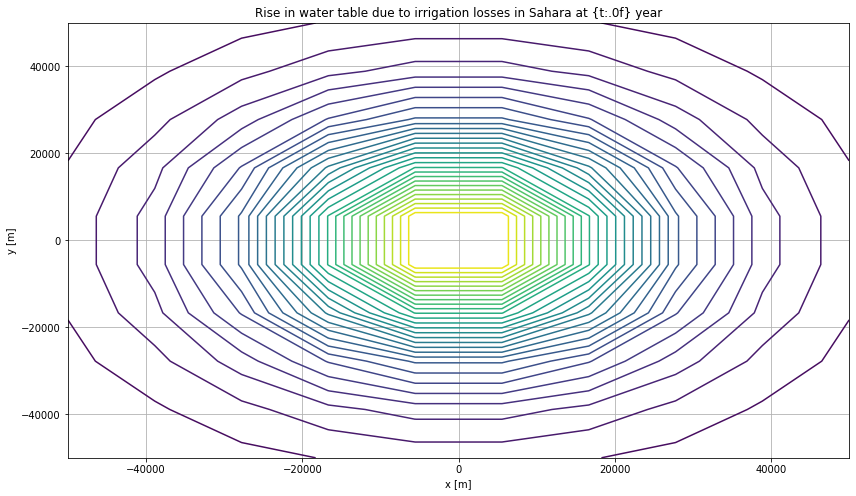

In [30]:
# Contouring the situation at t = 50 years

ax = newfig('Rise in water table due to irrigation losses in Sahara at {t:.0f} year', 'x [m]', 'y [m]')

t = 50 # years

s = np.zeros_like(X0)

for xwi in Xw.ravel():
    for ywi in Yw.ravel():
        R = np.sqrt((X0 - xwi)**2 + (Y0 - ywi)**2)
        s += Q/(4 * np.pi * kD) * exp1(R**2 * S/ (4 * kD * t))
ax.contour(X0, Y0, s, levels=30)
